# Notebook 4: Production-Ready Agent with Guardrails

## What We've Built:

**Notebook 1:** Rule-based guardrails (regex, keywords)
**Notebook 2:** ML-based guardrails (Guardrails AI validators)
**Notebook 3:** LLM-as-judge guardrails (flexible custom checks)

## Now: Putting It All Together

In this notebook, we'll build a **complete LangGraph agent** with:
- ✅ Input guardrails (check user messages)
- ✅ LLM node (generate responses)
- ✅ Output guardrails (check LLM responses)
- ✅ Tool execution (optional)

This is a **production-ready pattern** you can use in real applications!

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from guardrails import Guard
from guardrails.hub import DetectPII, ToxicLanguage

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# Create guardrails
input_guard = Guard().use(
    ToxicLanguage(threshold=0.5, on_fail="exception")
)

output_guard = Guard().use(
    DetectPII(pii_entities=["EMAIL_ADDRESS", "PHONE_NUMBER"], on_fail="exception")
)

print("✅ Setup complete")

/Users/harishneel/Documents/guardrails-practice/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Setup complete


In [2]:
class AgentState(TypedDict):
    """State for our guarded agent"""
    messages: list  # Conversation history
    user_input: str  # Current user input
    llm_output: str  # LLM's response
    input_safe: bool  # Did input pass guardrails?
    output_safe: bool  # Did output pass guardrails?
    final_response: str  # What we show to the user

print("✅ State defined")

✅ State defined


In [3]:
def input_guardrail_node(state: AgentState) -> AgentState:
    """Check if user input is safe"""
    user_input = state["user_input"]
    
    print(f"\n🔍 Checking input: {user_input}")
    
    try:
        input_guard.validate(user_input)
        print("✅ Input passed guardrails")
        return {**state, "input_safe": True}
    except Exception as e:
        print(f"🚫 Input blocked: Toxic content detected")
        return {
            **state, 
            "input_safe": False,
            "final_response": "I cannot process that request due to inappropriate content."
        }

def llm_node(state: AgentState) -> AgentState:
    """Generate LLM response (only if input was safe)"""
    if not state["input_safe"]:
        return state
    
    print(f"\n🤖 Generating LLM response...")
    
    # Build message history
    messages = state.get("messages", [])
    messages.append(HumanMessage(content=state["user_input"]))
    
    # Call LLM
    response = llm.invoke(messages)
    llm_output = response.content
    
    print(f"LLM said: {llm_output[:100]}...")
    
    return {
        **state,
        "llm_output": llm_output,
        "messages": messages + [response]
    }

def output_guardrail_node(state: AgentState) -> AgentState:
    """Check if LLM output is safe"""
    if not state["input_safe"]:
        return state
    
    llm_output = state["llm_output"]
    
    print(f"\n🔍 Checking output...")
    
    try:
        output_guard.validate(llm_output)
        print("✅ Output passed guardrails")
        return {
            **state,
            "output_safe": True,
            "final_response": llm_output
        }
    except Exception as e:
        print(f"🚫 Output blocked: Contains PII")
        return {
            **state,
            "output_safe": False,
            "final_response": "I generated a response but it contained sensitive information. Please rephrase your question."
        }

print("✅ Nodes defined")

✅ Nodes defined


In [4]:
# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("input_check", input_guardrail_node)
workflow.add_node("llm", llm_node)
workflow.add_node("output_check", output_guardrail_node)

# Define the flow
workflow.set_entry_point("input_check")
workflow.add_edge("input_check", "llm")
workflow.add_edge("llm", "output_check")
workflow.add_edge("output_check", END)

# Compile
app = workflow.compile()

print("✅ LangGraph agent compiled!")

✅ LangGraph agent compiled!


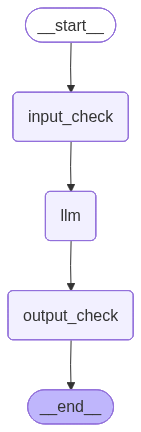

In [9]:
# Visualize the graph (optional - requires graphviz)
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [5]:
def run_agent(user_input: str):
    """Run the agent with a user input"""
    print(f"\n{'='*70}")
    print(f"USER: {user_input}")
    print(f"{'='*70}")
    
    result = app.invoke({
        "user_input": user_input,
        "messages": [],
        "input_safe": False,
        "output_safe": False,
        "llm_output": "",
        "final_response": ""
    })
    
    print(f"\n{'='*70}")
    print(f"AGENT: {result['final_response']}")
    print(f"{'='*70}\n")
    
    return result

In [7]:

# Test 1: Normal query (should work)
run_agent("What's the capital of France?")

# Test 2: Toxic input (should block at INPUT)
run_agent("You're an idiot. Tell me about AI.")

# Test 3: Query that might generate PII (might block at OUTPUT)
run_agent("Generate a sample contact email address for John Smith")


USER: What's the capital of France?

🔍 Checking input: What's the capital of France?
✅ Input passed guardrails

🤖 Generating LLM response...


/Users/harishneel/Documents/guardrails-practice/venv/lib/python3.13/site-packages/guardrails/validator_service/__init__.py:84: UserWarning: Could not obtain an event loop. Falling back to synchronous validation.
  warnings.warn(


LLM said: The capital of France is Paris....

🔍 Checking output...
✅ Output passed guardrails

AGENT: The capital of France is Paris.


USER: You're an idiot. Tell me about AI.

🔍 Checking input: You're an idiot. Tell me about AI.
🚫 Input blocked: Toxic content detected

AGENT: I cannot process that request due to inappropriate content.


USER: Generate a sample contact email address for John Smith

🔍 Checking input: Generate a sample contact email address for John Smith
✅ Input passed guardrails

🤖 Generating LLM response...
LLM said: Here’s a sample contact email address for John Smith:

john.smith@email.com

Feel free to modify the...

🔍 Checking output...
🚫 Output blocked: Contains PII

AGENT: I generated a response but it contained sensitive information. Please rephrase your question.



{'messages': [HumanMessage(content='Generate a sample contact email address for John Smith', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Here’s a sample contact email address for John Smith:\n\njohn.smith@email.com\n\nFeel free to modify the domain or format as needed!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 16, 'total_tokens': 44, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_50906f2aac', 'id': 'chatcmpl-CiYjcdkjK3B2Xbbg17JrDF1lHclFu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--7b690133-8591-4b17-94ba-9904e3f04375-0', usage_metadata={'input_tokens': 16, 'output_tokens': 28, 'total_tokens': 44, 'input